## API clima

In [1]:
if __name__=="__main__":

    import requests
    import pandas as pd

    url_base = "http://www.7timer.info/bin/astro.php"
    parametros = {"lon": "-58.38",
                "lat": "-34.60",
                "ac": "0",
                "unit": "metric",
                "output": "json",
                "tzshift": "0"}

    response = requests.get(url_base, params = parametros)

    if response.status_code == 200:
        response_json = response.json()

        if 'dataseries' in response_json:

            valor_anio = response_json['init'][:4]
            valor_mes = response_json['init'][4:6]
            valor_dia = response_json['init'][6:8]

            #Creamos un diccionario con claves y los valores contenidos en listas para almacenar los datos extraidos desde la API
            diccionario = {'Pronostico': [], 'cloudcover': [], 'seeing': [], 'transparency': [], 'lifted_index': [], 'rh2m': [], 'wind10m_speed': [], 'temp2m': [], 'prec_type': [], 'Year': [], 'Month': [], 'Day': []}

            for elemento in response_json['dataseries']:
                diccionario['Pronostico'].append(str(elemento['timepoint'])+"h")
                diccionario['cloudcover'].append(elemento['cloudcover'])
                diccionario['seeing'].append(elemento['seeing'])
                diccionario['transparency'].append(elemento['transparency'])
                diccionario['lifted_index'].append(elemento['lifted_index'])
                diccionario['rh2m'].append(elemento['rh2m'])
                diccionario['wind10m_speed'].append(elemento['wind10m']['speed'])
                diccionario['temp2m'].append(elemento['temp2m'])
                diccionario['prec_type'].append(elemento['prec_type'])
                diccionario['Year'].append(valor_anio)
                diccionario['Month'].append(valor_mes)
                diccionario['Day'].append(valor_dia)  

#            for clave, valor in diccionario.items():
#                print(f"longitud {clave}: {len(diccionario[clave])}")

            dicc_nuevo = pd.DataFrame(diccionario)
            print(dicc_nuevo)

    else:
        print(f"error: {response.status_code}")

   Pronostico  cloudcover  seeing  transparency  lifted_index  rh2m  \
0          3h           1       7             2            15     5   
1          6h           1       7             2            15     4   
2          9h           1       7             2            15     4   
3         12h           1       7             2            15     5   
4         15h           1       8             2            15     4   
5         18h           1       7             2            15     6   
6         21h           1       7             2            15     7   
7         24h           1       7             2            15     7   
8         27h           1       7             2            15     4   
9         30h           1       7             2            15     3   
10        33h           1       7             2            15     3   
11        36h           1       8             2            15     5   
12        39h           1       8             2            15     5   
13    

## Conexion a postgresql

In [2]:
import psycopg2

data_base = 'coderhouse_semana_3'
user = 'postgres'

with open("C:/Users/cquir/OneDrive/Escritorio/python/passwords/postgresql clima api.txt", 'r') as f:
    passw = f.read()

try:
    conn = psycopg2.connect(database=data_base, user=user, password=passw)
    print('Conectado con éxito a Postgres')

except Exception as e:
    print(f'No se pudo conectar a Postgres. Error: {e}')  


Conectado con éxito a Postgres


## Funcion ETL

In [3]:
#Revisamos los tipos de datos para reemplazarlos y que sean compatibles en SQL
dicc_nuevo.dtypes

Pronostico       object
cloudcover        int64
seeing            int64
transparency      int64
lifted_index      int64
rh2m              int64
wind10m_speed     int64
temp2m            int64
prec_type        object
Year             object
Month            object
Day              object
dtype: object

In [4]:
from psycopg2.extras import execute_values

def cargar_a_postgres(conexion, nombre_tabla, dataframe):
    try:
        dtypes = dataframe.dtypes
        cols = list(dtypes.index)
        tipos = list(dtypes.values)
        #Equivalencia python-postgres de tipo de dato 
        datos_python_sql = {'int64': 'INT', 'int32': 'INT', 'float64': 'FLOAT', 'object': 'VARCHAR(100)', 'bool': 'BOOLEAN'} 
        sql_dtypes = [datos_python_sql[str(tipo)] for tipo in tipos]

        # Definir formato SQL "VARIABLE TIPO_DATO"
        variable_tipo_dato = [f'{nombre} {tipo}' for nombre, tipo in zip(cols, sql_dtypes)]

        # Sentencia para la creacion de tabla nombre (columna1 tipo1, columna2 tipo2 ...)
        table_schema = f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({', '.join(variable_tipo_dato)});"

        #aseguramos que el cursos se cierre completamente al completar el bloque
        with conexion.cursor() as cur:
            # Crear la tabla
            cur.execute(table_schema)
            # Generar los valores a insertar
            valores = [tuple(x) for x in dataframe.to_numpy()]
            # Definir el INSERT
            insert_sql = f"INSERT INTO {nombre_tabla} ({', '.join(cols)}) VALUES %s"

            # Ejecutamos para insertar los datos 
            cur.execute("BEGIN")
            execute_values(cur, insert_sql, valores)
            cur.execute("COMMIT")
        print('Carga de datos a postgres terminada')
    except Exception as e:
        #aseguramos que se deshagan los cambios realizados 
        conn.rollback()
        print(f"Hubo un error durante el proceso: {e}")
    #aseguramos el cierre total de la conexion
    finally:
        conn.close()



## Trigger de ETL

In [5]:
cargar_a_postgres(conexion=conn, nombre_tabla='datos_api_clima', dataframe=dicc_nuevo)

Carga de datos a postgres terminada


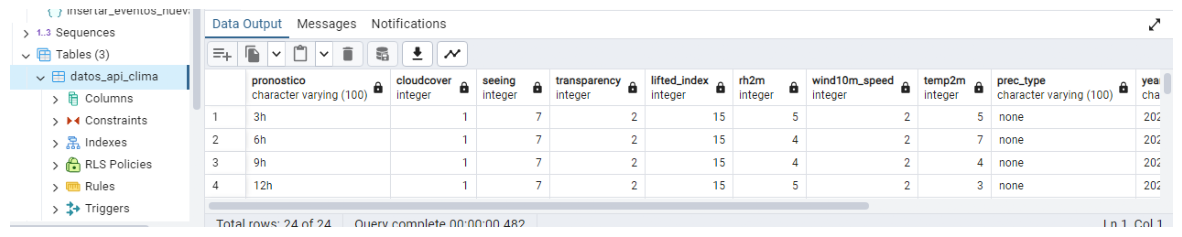